# Factor Analysis - Average Sentiment Signal

### Imports

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from quantopian.pipeline.filters import Q1500US
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.filters.fundamentals import IsPrimaryShare
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import CustomFactor, Returns
from quantopian.pipeline.classifiers.fundamentals import Sector
from quantopian.pipeline.data.sentdex import sentiment_free
from quantopian.pipeline.factors import SimpleMovingAverage
from time import time
import alphalens as al

### Average Sentiment Custom Factor

In [14]:
class AvgSentiment(CustomFactor):
    def compute(self, today, assets, out, impact):
        np.mean(impact, axis=0, out=out)

In [4]:
MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,
}

### Average Daily Dollar Volume Traded Custom Factor

In [5]:
class AvgDailyDollarVolumeTraded(CustomFactor):
    window_length = 20
    inputs = [USEquityPricing.close, USEquityPricing.volume]
    def compute(self, today, assets, out, close_price, volume):
        out[:] = np.mean(close_price * volume, axis=0)

# Pipeline

In [17]:
window_length =3
pipe = Pipeline()
dollar_volume = AvgDailyDollarVolumeTraded()
pipe.add(Sector(), 'Sector')
# Add our AvgSentiment factor to the pipeline using a 3 day moving average
pipe.add(AvgSentiment(inputs=[sentiment_free.sentiment_signal], window_length=window_length), "avg_sentiment")
# Screen out low liquidity securities.
pipe.set_screen((dollar_volume > 10**7))
start_timer = time()
results = run_pipeline(pipe, '2015-01-01', '2016-01-01')
end_timer = time()


print("Time to run pipeline %.2f secs" % (end_timer - start_timer))

Time to run pipeline 9.05 secs


In [18]:
adjusted_dataset = results.interpolate()
adjusted_dataset.head()

Sector  avg_sentiment
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])      101       2.000000
                          Equity(24 [AAPL])     311       4.000000
                          Equity(41 [ARCB])     310       2.555556
                          Equity(53 [ABMD])     206       1.111111
                          Equity(62 [ABT])      206      -0.333333

In [19]:
avgsent_factor = adjusted_dataset["avg_sentiment"]
print(avgsent_factor.head())

2015-01-02 00:00:00+00:00  Equity(2 [ARNC])     2.000000
                           Equity(24 [AAPL])    4.000000
                           Equity(41 [ARCB])    2.555556
                           Equity(53 [ABMD])    1.111111
                           Equity(62 [ABT])    -0.333333
Name: avg_sentiment, dtype: float64


In [20]:
sectors = adjusted_dataset['Sector']

In [21]:
asset_list = adjusted_dataset.index.levels[1].unique()
prices = get_pricing(asset_list, start_date='2015-01-01', end_date='2016-01-01', fields='price')
len(asset_list)


2982

In [22]:
prices.head()


,Equity(2 [ARNC]),Equity(24 [AAPL]),Equity(31 [ABAX]),Equity(41 [ARCB]),Equity(52 [ABM]),Equity(53 [ABMD]),Equity(62 [ABT]),Equity(64 [ABX]),Equity(66 [AB]),Equity(67 [ADSK]),...,Equity(49501 [LIVN]),Equity(49506 [HPE]),Equity(49511 [NRE]),Equity(49515 [RACE]),Equity(49526 [AVXL]),Equity(49543 [FCPT]),Equity(49569 [KMI_PRA]),Equity(49608 [MTCH]),Equity(49610 [SQ]),Equity(49630 [CSRA])
2015-01-02 00:00:00+00:00,15.717,107.469,57.253,45.513,27.971,37.30,43.977,10.768,24.359,59.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05 00:00:00+00:00,14.817,104.470,57.124,44.839,28.039,37.09,43.997,10.748,23.509,58.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06 00:00:00+00:00,14.906,104.451,56.648,42.805,28.167,36.13,43.478,11.103,23.005,57.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07 00:00:00+00:00,15.302,105.945,56.638,41.734,28.650,37.28,43.840,10.965,23.229,57.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08 00:00:00+00:00,15.757,109.996,58.047,42.716,28.965,38.96,44.731,10.659,23.808,58.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Alphalens Factor Analysis


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-3.000000,0.939394,-1.299866,0.810656,252354,50.166989
2,-0.987654,6.000000,2.253128,1.654734,250674,49.833011


Returns Analysis


,1,5,10
Ann. alpha,0.002,-0.000,-0.004
beta,-0.015,-0.017,-0.026
Mean Period Wise Return Top Quantile (bps),0.274,0.286,-0.098
Mean Period Wise Return Bottom Quantile (bps),-0.272,-0.284,0.097
Mean Period Wise Spread (bps),0.548,0.122,-0.017


/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:727: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=1,window=5).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:767: FutureWarning: pd.rolling_apply is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,min_periods=1,window=5).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:727: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=1,window=10).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/usr/local/lib/python2.7/dist-packages/alphalens/pl

Information Analysis


,1,5,10
IC Mean,0.001,0.003,0.002
IC Std.,0.034,0.032,0.032
t-stat(IC),0.505,1.327,0.880
p-value(IC),0.614,0.186,0.380
IC Skew,-0.059,0.180,0.007
IC Kurtosis,-0.399,0.027,-0.245
Ann. IR,0.515,1.354,0.898


/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:215: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False).mean()
  pd.rolling_mean(ic, 22).plot(ax=a,


Turnover Analysis


,1,5,10
Quantile 1 Mean Turnover,0.062,0.175,0.231
Quantile 2 Mean Turnover,0.063,0.180,0.241


,1,5,10
Mean Factor Rank Autocorrelation,0.956,0.747,0.639


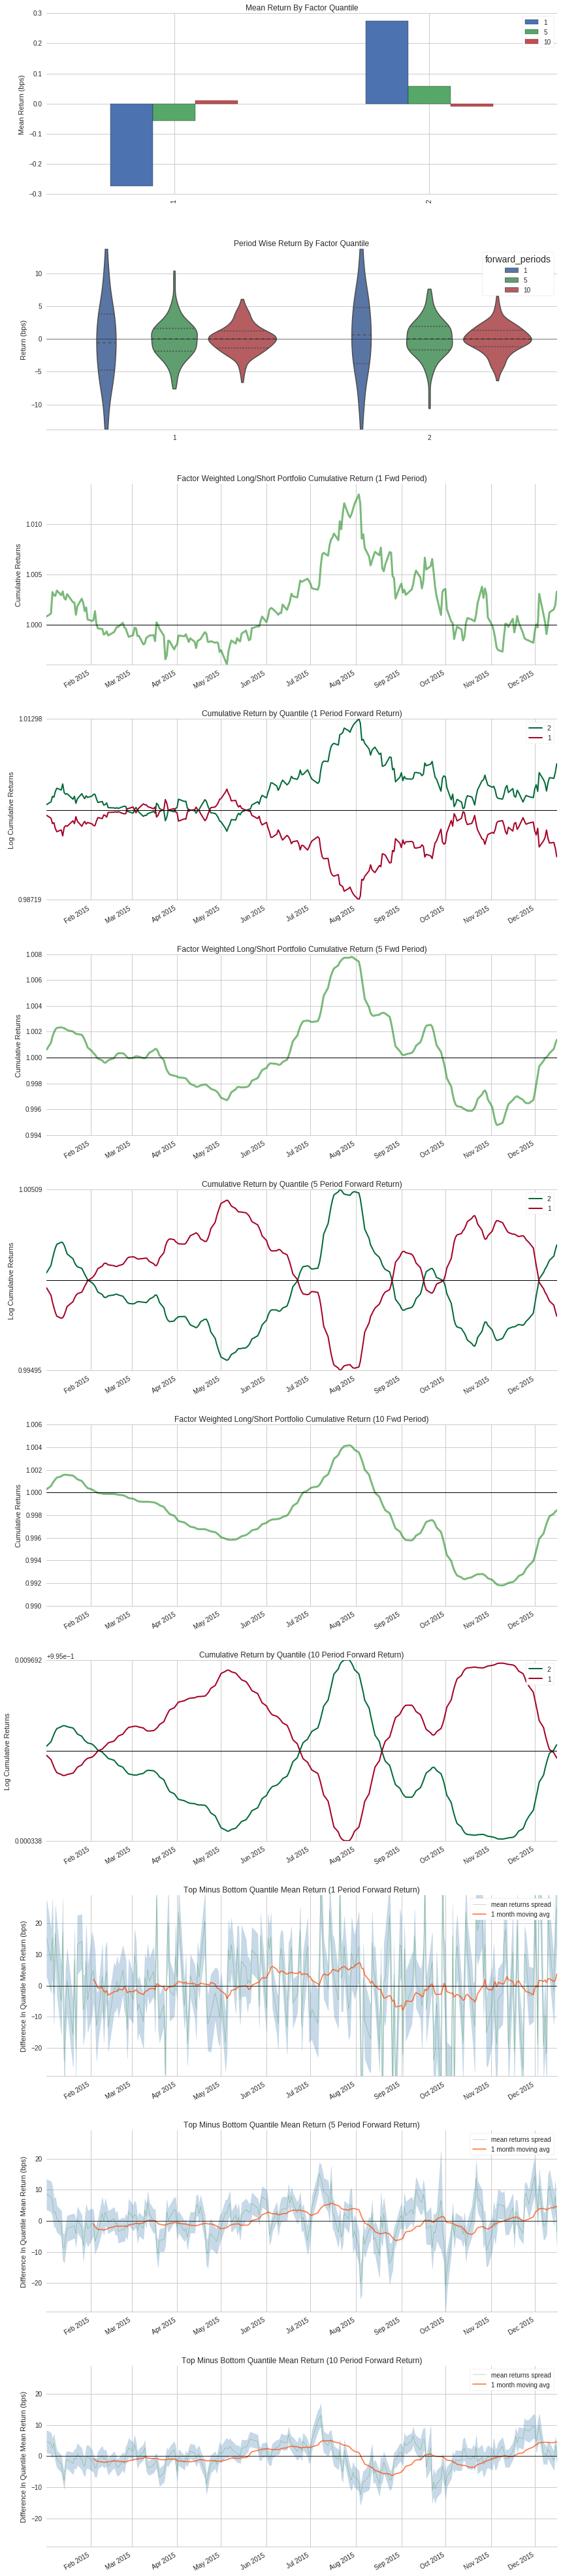

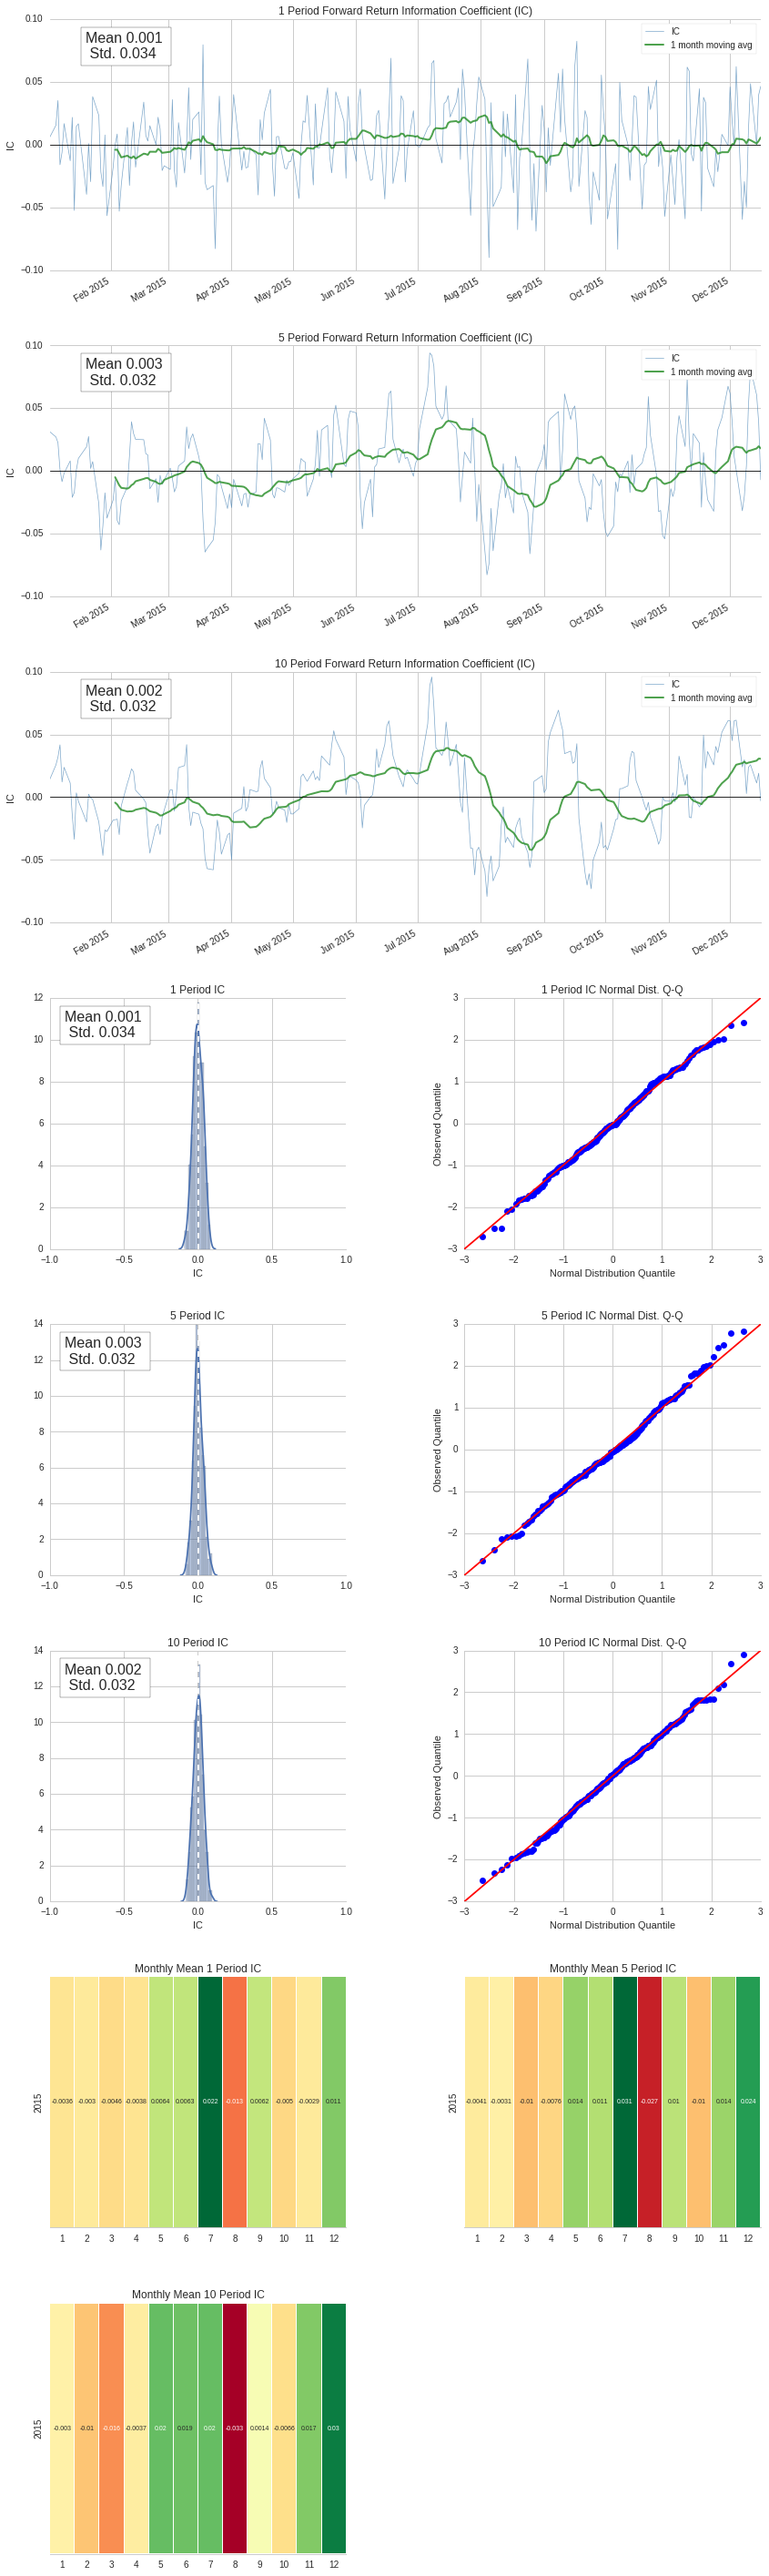

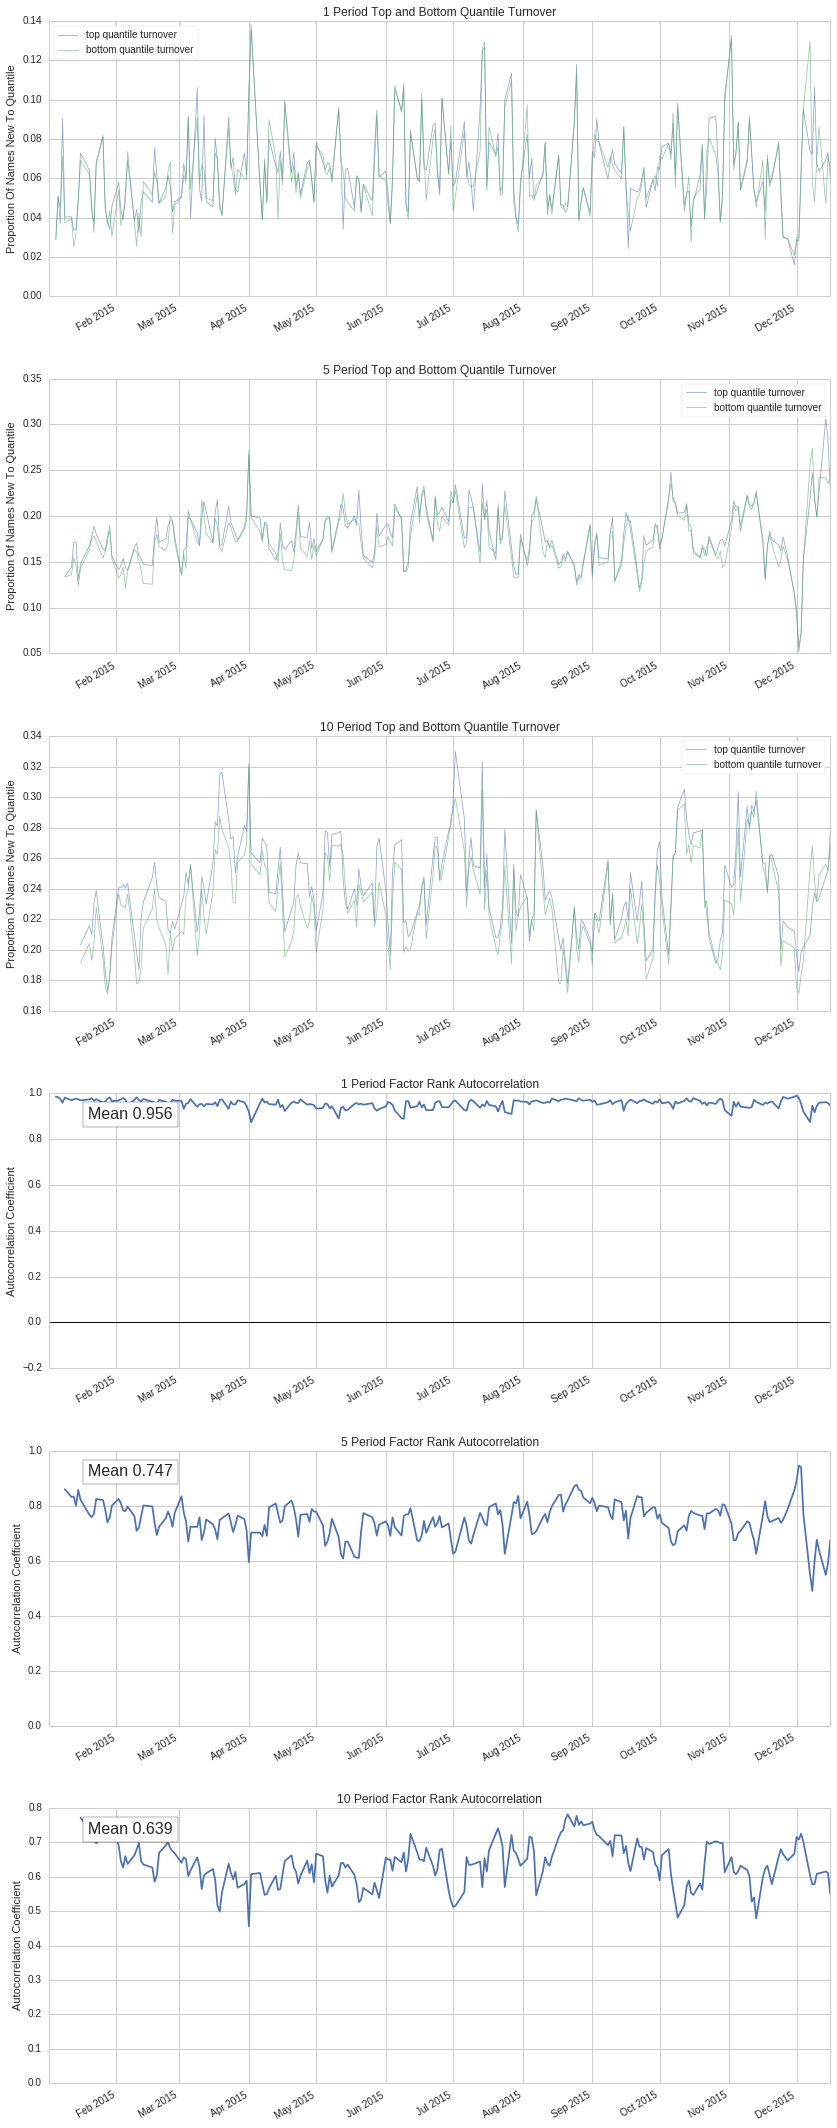

In [29]:
avgsent_factor_data = al.utils.get_clean_factor_and_forward_returns(
                                                            factor=avgsent_factor,
                                                            prices=prices,
                                                            groupby=sectors,
                                                            quantiles=2,
                                                            groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                            periods=(1, 5, 10))
avgsent_factor_data.head()
al.tears.create_full_tear_sheet(avgsent_factor_data)

In [31]:
mean_return_by_q_daily, std_err_by_q_daily = al.performance.mean_return_by_quantile(avgsent_factor_data,
                                                                                    by_date=True)
mean_return_by_q_daily.head()

1         5         10
factor_quantile date                                                   
1               2015-01-02 00:00:00+00:00 -0.000768 -0.002132 -0.002387
                2015-01-05 00:00:00+00:00 -0.000395 -0.001956 -0.002046
                2015-01-06 00:00:00+00:00 -0.000769 -0.001570 -0.001240
                2015-01-07 00:00:00+00:00  0.000121 -0.000664 -0.002018
                2015-01-08 00:00:00+00:00 -0.000849 -0.000707 -0.000541

In [32]:
mean_return_by_q, std_err_by_q = al.performance.mean_return_by_quantile(avgsent_factor_data,
                                                                        by_group=False)
mean_return_by_q.head()

,1,5,10
factor_quantile,,,
1,-0.000027,-0.000028,0.00001
2,0.000027,0.000029,-0.00001


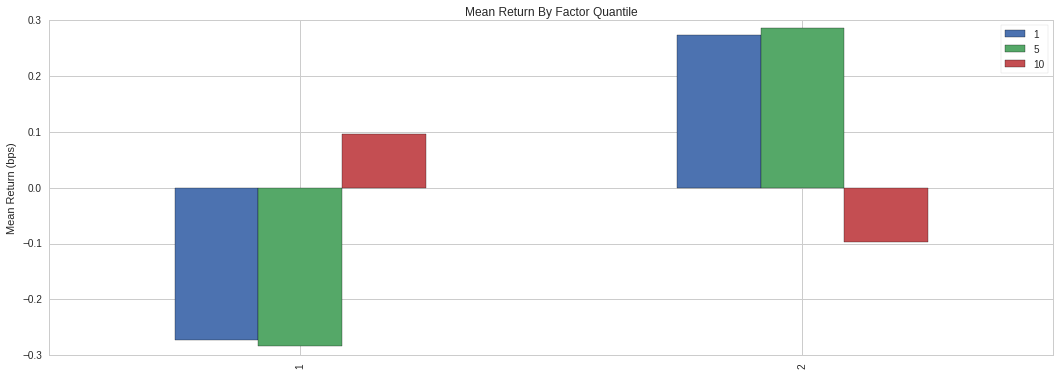

In [33]:
al.plotting.plot_quantile_returns_bar(mean_return_by_q)

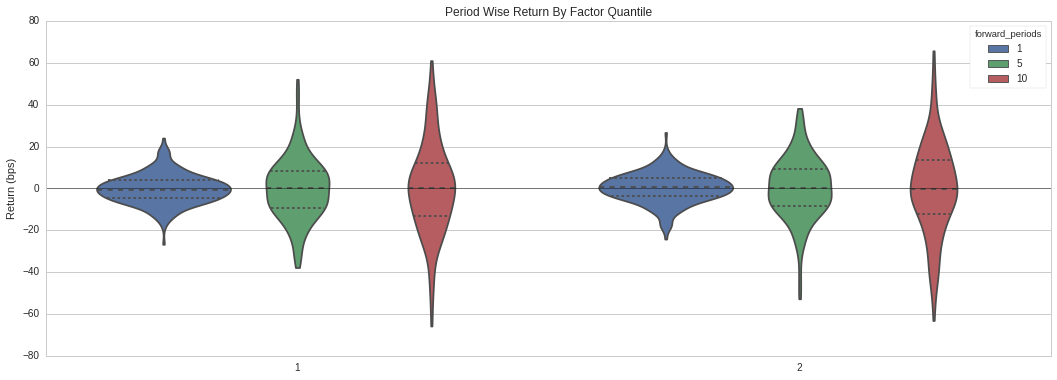

In [34]:
al.plotting.plot_quantile_returns_violin(mean_return_by_q_daily)